# مدل های یکسان و بدون باگ

In [6]:
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import pandas as pd
import nest_asyncio
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
from sklearn.cluster import DBSCAN

nest_asyncio.apply()

# تنظیم بذر تصادفی برای تکرارپذیری
np.random.seed(42)
tf.random.set_seed(42)

# تنظیم زمینه اجرایی محلی
tff.backends.native.set_local_execution_context()

def load_and_preprocess_mnist():
    """
    بارگذاری دیتاست MNIST و پیش‌پردازش داده‌ها:
    - نرمال‌سازی داده‌ها
    - تبدیل نوع داده‌ها به float32
    """
    # بارگذاری دیتاست MNIST
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    
    # نرمال‌سازی داده‌ها
    x_train = x_train[..., np.newaxis] / 255.0
    x_test = x_test[..., np.newaxis] / 255.0

    # تبدیل نوع داده‌ها به float32
    x_train = x_train.astype(np.float32)
    x_test = x_test.astype(np.float32)
    
    return (x_train, y_train), (x_test, y_test)

def split_data_for_clients(x_train, y_train, n_clients):
    """
    تقسیم داده‌های آموزش به صورت بدون همپوشانی بین کلاینت‌ها.
    
    Parameters:
        x_train (numpy.ndarray): داده‌های آموزش
        y_train (numpy.ndarray): برچسب‌های آموزش
        n_clients (int): تعداد کلاینت‌ها
        
    Returns:
        list: لیست داده‌های تقسیم‌شده به صورت (x_client, y_client)
    """
    n_samples = x_train.shape[0]
    client_data = []
    data_per_client = n_samples // n_clients

    for i in range(n_clients):
        start_idx = i * data_per_client
        end_idx = start_idx + data_per_client
        x_client = x_train[start_idx:end_idx]
        y_client = y_train[start_idx:end_idx]
        client_data.append((x_client, y_client))
    
    return client_data

# استفاده از توابع
n_clients = 5  # تعداد کلاینت‌ها
(x_train, y_train), (x_test, y_test) = load_and_preprocess_mnist()
client_data = split_data_for_clients(x_train, y_train, n_clients)

# تابع برای ایجاد مدل CNN با هایپرتنظیمات مختلف
def create_cnn_model(learning_rate=0.001, dropout_rate=0.5):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model
 
# def generate_hyperparameters(n_clients):
#     base_lr = 0.001
#     base_dropout = 0.5
#     hyperparameters = []
#     for i in range(n_clients):
#         if i + 1 == 4:  # اعمال شرط برای کلاینت 4
#             lr = 100.0
#         else:
#             lr = base_lr * (2 ** (i % 3))
#         if i + 1 == 4:  # اعمال شرط برای کلاینت 4
#              dropout = 0.8
#         else:
#             dropout = base_dropout - 0.1 * (i % 3)
#         hyperparameters.append({'learning_rate': lr, 'dropout_rate': dropout})
#     return hyperparameters


def generate_hyperparameters(n_clients):
    base_lr = 0.001
    base_dropout = 0.5
    hyperparameters = []
    for i in range(n_clients):
        lr = base_lr 
        dropout = base_dropout
        hyperparameters.append({'learning_rate': lr, 'dropout_rate': dropout})
    return hyperparameters




  # هایپرتنظیمات برای هر کلاینت
hyperparameters = generate_hyperparameters(n_clients)

# آموزش مدل‌ها برای هر کلاینت
client_models = []

for i, params in enumerate(hyperparameters):
    lr = params['learning_rate']  # استخراج learning_rate از params
    model = create_cnn_model(learning_rate=lr, dropout_rate=params['dropout_rate'])
    client_models.append(model)
    
    # آماده‌سازی داده‌ها برای آموزش
    x_client, y_client = client_data[i]
    
    # آموزش مدل کلاینت
    model.fit(x_client, y_client, epochs=5, batch_size=32, verbose=1)
    
    # ذخیره پارامترهای مدل به صورت فایل (برای ارسال به سرور)
    model.save(f'client_model_{i}.h5')

Epoch 1/5
375/375 [==============================] - 7s 18ms/step - loss: 0.6330 - accuracy: 0.7934
Epoch 2/5
375/375 [==============================] - 7s 17ms/step - loss: 0.2022 - accuracy: 0.9435
Epoch 3/5
375/375 [==============================] - 7s 18ms/step - loss: 0.1477 - accuracy: 0.9582
Epoch 4/5
375/375 [==============================] - 6s 16ms/step - loss: 0.1115 - accuracy: 0.9678
Epoch 5/5
375/375 [==============================] - 7s 19ms/step - loss: 0.0897 - accuracy: 0.9737
Epoch 1/5
375/375 [==============================] - 6s 17ms/step - loss: 0.6653 - accuracy: 0.7843
Epoch 2/5
375/375 [==============================] - 7s 18ms/step - loss: 0.2122 - accuracy: 0.9342
Epoch 3/5
375/375 [==============================] - 7s 19ms/step - loss: 0.1453 - accuracy: 0.9580
Epoch 4/5
375/375 [==============================] - 7s 19ms/step - loss: 0.1061 - accuracy: 0.9690
Epoch 5/5
375/375 [==============================] - 7s 19ms/step - loss: 0.0857 - accuracy: 0.9736


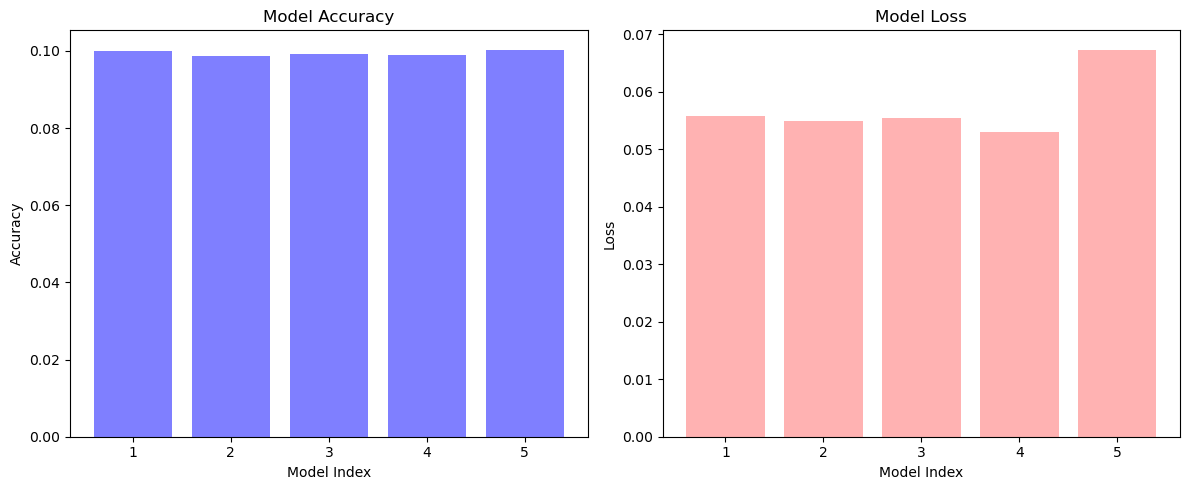

In [7]:

def load_model(file_path):
    """
    بارگذاری مدل از فایل
    """
    return tf.keras.models.load_model(file_path)

def evaluate_models(models, x_test, y_test):
    """
    ارزیابی مدل‌ها با استفاده از داده‌های تست و بازگشت نتایج
    
    Parameters:
        models (list): لیست مدل‌های بارگذاری‌شده
        x_test (numpy.ndarray): داده‌های تست
        y_test (numpy.ndarray): برچسب‌های تست
        
    Returns:
        list: لیست نتایج ارزیابی برای هر مدل (دقت و دیگر متریک‌ها)
    """
    results = []
    for model in models:
        # ارزیابی مدل
        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
        results.append((test_loss, test_acc))
    
    return results

def plot_results(results):
    """
    نمایش نتایج ارزیابی به صورت نمودار
    """
    losses, accuracies = zip(*results)
    
# تغییر مقادیر محور x به طوری که از 1 شروع شود
    x = range(1, len(results) + 1)    
    plt.figure(figsize=(12, 5))

    # نمودار دقت
    plt.subplot(1, 2, 1)
    plt.bar(x, accuracies, color='blue',alpha=0.5)
    plt.xlabel('Model Index')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')

    # نمودار خطا
    plt.subplot(1, 2, 2)
    plt.bar(x, losses, color='red',alpha=0.3)
    plt.xlabel('Model Index')
    plt.ylabel('Loss')
    plt.title('Model Loss')

    plt.tight_layout()
    plt.show()

# بارگذاری مدل‌ها
models = [load_model(f'client_model_{i}.h5') for i in range(n_clients)]

# ارزیابی مدل‌ها
results = evaluate_models(models, x_test, y_test)

# نمایش نتایج
plot_results(results)


C:\Users\TOP\AppData\Local\Temp\ipykernel_4876\2440206899.py:29: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  P_KS, _ = stats.ks_2samp(preds1, preds2)


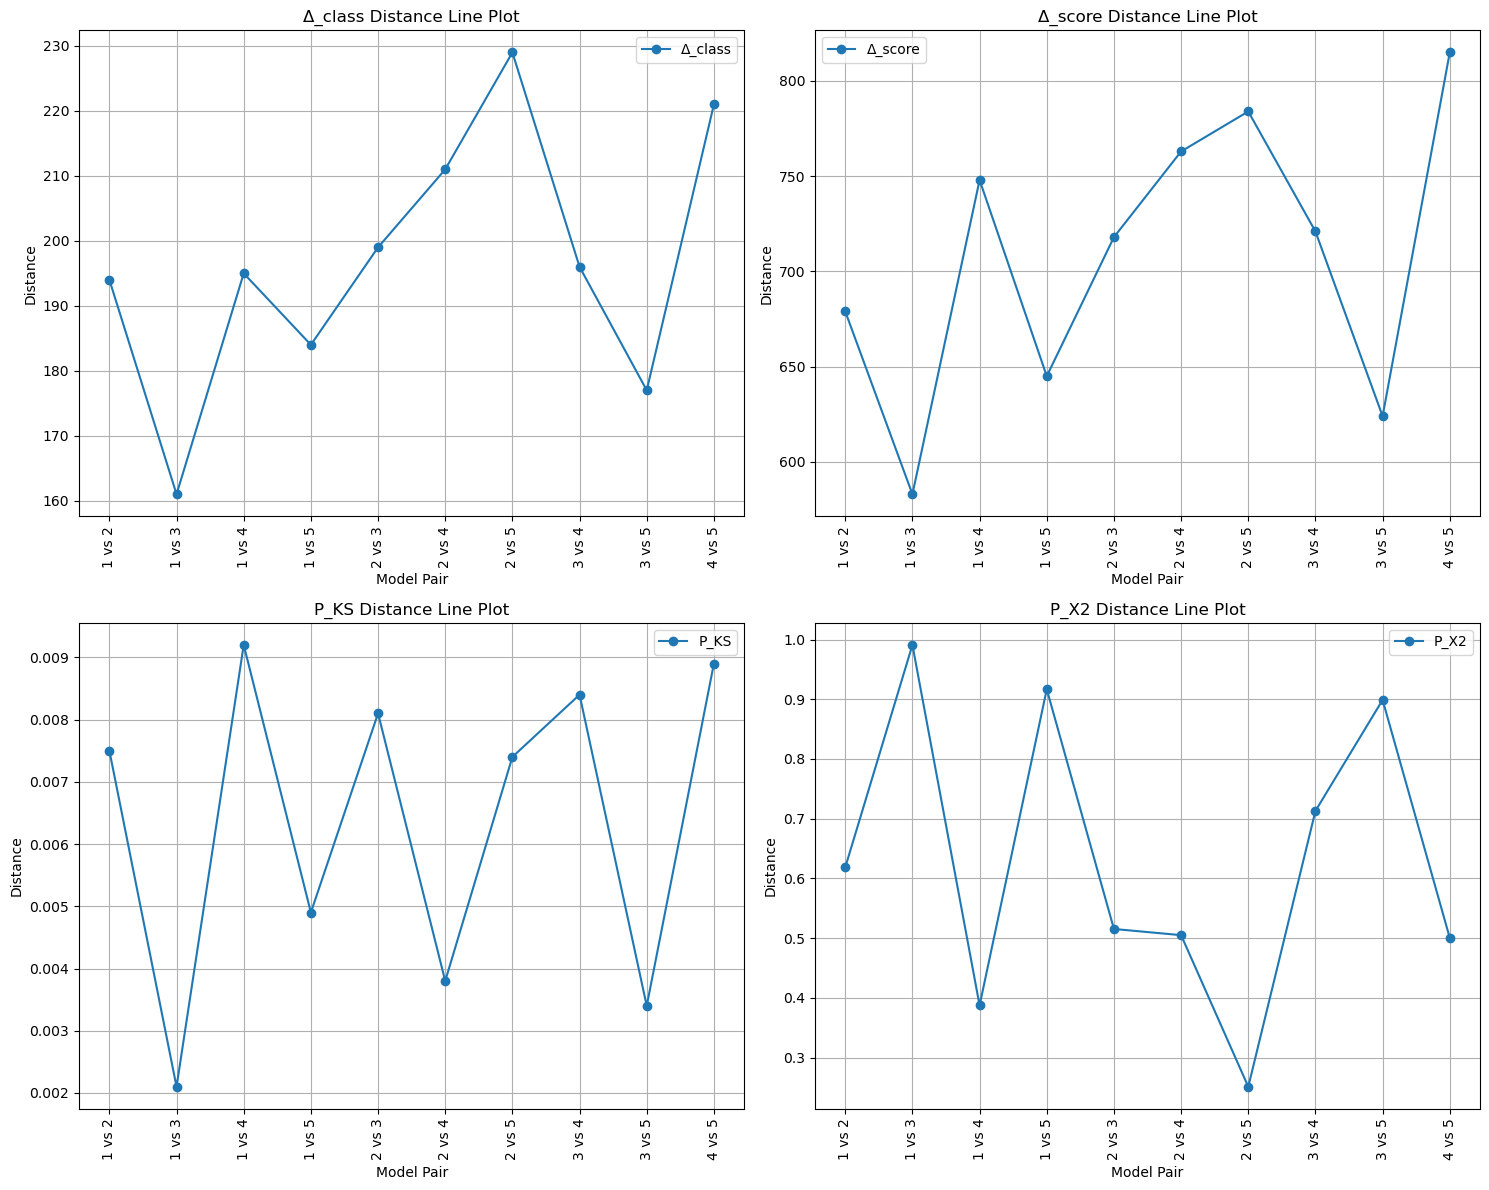

  Comparison  Δ_class  Δ_score    P_KS      P_X2
0     (1, 2)    194.0    679.0  0.0075  0.618549
1     (1, 3)    161.0    583.0  0.0021  0.990976
2     (1, 4)    195.0    748.0  0.0092  0.387261
3     (1, 5)    184.0    645.0  0.0049  0.916700
4     (2, 3)    199.0    718.0  0.0081  0.515262
5     (2, 4)    211.0    763.0  0.0038  0.504910
6     (2, 5)    229.0    784.0  0.0074  0.251030
7     (3, 4)    196.0    721.0  0.0084  0.712979
8     (3, 5)    177.0    624.0  0.0034  0.898863
9     (4, 5)    221.0    815.0  0.0089  0.500341


In [8]:

def perform_differential_testing(preds1, preds2):
    """
    محاسبه متریک‌های تفاوت بین دو پیش‌بینی.
    
    Parameters:
        preds1 (array): پیش‌بینی‌های مدل اول
        preds2 (array): پیش‌بینی‌های مدل دوم
    
    Returns:
        tuple: مقادیر متریک‌ها (Δ_class, Δ_score, P_KS, P_X2)
    """
    # اطمینان از اینکه preds1 و preds2 به صورت یک‌بعدی هستند
    preds_class1 = np.argmax(preds1, axis=1).astype(int)
    preds_class2 = np.argmax(preds2, axis=1).astype(int)
    
    # تبدیل پیش‌بینی‌ها به برچسب‌های صحیح در صورتی که پیش‌بینی‌ها به صورت احتمالات باشند
    if preds1.ndim > 1:
        preds1 = np.argmax(preds1, axis=1)
    if preds2.ndim > 1:
        preds2 = np.argmax(preds2, axis=1)
         
    # محاسبه Δ_class
    Δ_class = np.sum(preds_class1 != preds2)
    
    # محاسبه Δ_score
    Δ_score = np.sum(np.abs(preds1 - preds2))
    
    # آزمون Kolmogorov-Smirnov برای نمرات
    P_KS, _ = stats.ks_2samp(preds1, preds2)
    
    # آزمون Chi-Squared برای کلاس‌ها
    bins = max(preds1.max(), preds2.max()) + 1
    contingency_table = np.array([np.bincount(preds1, minlength=bins), np.bincount(preds2, minlength=bins)])
    try:
        _, p_X2 = stats.chisquare(f_obs=contingency_table[0], f_exp=contingency_table[1])
    except ValueError:
        p_X2 = np.nan
       
    return Δ_class, Δ_score, P_KS, p_X2

def compute_distance_matrices(predictions_list):
    """
    محاسبه ماتریس‌های فاصله برای چهار متریک.
    
    Parameters:
        predictions_list (list): لیست پیش‌بینی‌های مدل‌ها
        
    Returns:
        dict: دیکشنری حاوی ماتریس‌های فاصله برای هر متریک
    """
    n_models = len(predictions_list)
    distance_matrices = {
        'Δ_class': np.zeros((n_models, n_models)),
        'Δ_score': np.zeros((n_models, n_models)),
        'P_KS': np.zeros((n_models, n_models)),
        'P_X2': np.zeros((n_models, n_models))
    }
    
    for i in range(n_models):
        for j in range(i + 1, n_models):  # فقط مقایسه‌های منحصر به فرد
            preds1 = predictions_list[i]
            preds2 = predictions_list[j]
            Δ_class, Δ_score, P_KS, P_X2 = perform_differential_testing(preds1, preds2)
            distance_matrices['Δ_class'][i, j] = Δ_class
            distance_matrices['Δ_class'][j, i] = Δ_class
            distance_matrices['Δ_score'][i, j] = Δ_score
            distance_matrices['Δ_score'][j, i] = Δ_score
            distance_matrices['P_KS'][i, j] = P_KS
            distance_matrices['P_KS'][j, i] = P_KS
            distance_matrices['P_X2'][i, j] = P_X2
            distance_matrices['P_X2'][j, i] = P_X2
    
    return distance_matrices



def plot_distance_matrices_lines(distance_matrices):
    """
    ترسیم نمودارهای خطی برای مقادیر متریک‌ها به ازای هر مقایسه مدل‌ها.
    
    Parameters:
        distance_matrices (dict): دیکشنری حاوی ماتریس‌های فاصله برای هر متریک
    """
    plt.close('all')
    
    metrics = list(distance_matrices.keys())
    n_models = len(distance_matrices[metrics[0]])  # تعداد مدل‌ها از اولین متریک گرفته می‌شود

    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    titles = [
        'Δ_class Distance Line Plot', 
        'Δ_score Distance Line Plot', 
        'P_KS Distance Line Plot', 
        'P_X2 Distance Line Plot'
    ]
    
    for ax, metric, title in zip(axs.flatten(), metrics, titles):
        distances = distance_matrices[metric]
        comparisons = []
        values = []
        # جمع‌آوری مقادیر فاصله برای نمودار
        for i in range(n_models):
            for j in range(i + 1, n_models):
                comparisons.append(f'{i + 1} vs {j + 1}')
                values.append(distances[i, j])
                
        ax.plot(comparisons, values, marker='o', linestyle='-', label=metric)
        ax.set_title(title)
        ax.set_xlabel('Model Pair')
        ax.set_ylabel('Distance')
        ax.legend()
        ax.grid(True)
        ax.set_xticklabels(comparisons, rotation=90)
    
    plt.tight_layout()
    plt.show()



def print_metric_tables(distance_matrices):
    """
    نمایش مقادیر متریک‌ها به صورت جدول.
    
    Parameters:
        distance_matrices (dict): دیکشنری حاوی ماتریس‌های فاصله برای هر متریک
    """
    rows = []
    metrics = list(distance_matrices.keys())
    n_models = len(distance_matrices[metrics[0]])  # تعداد مدل‌ها
    
    for i in range(n_models):
        for j in range(i + 1, n_models):  # فقط مقایسه‌های منحصر به فرد
            row = {'Comparison': f'({i + 1}, {j + 1})'}
            for metric in metrics:
                row[metric] = distance_matrices[metric][i, j]
            rows.append(row)
    
    df = pd.DataFrame(rows)
    print(df)


# فرض می‌کنیم predictions_list شامل پیش‌بینی‌های مدل‌ها است
predictions_list = [model.predict(x_test) for model in models]

# محاسبه ماتریس‌های فاصله
distance_matrices = compute_distance_matrices(predictions_list)

# نمایش نمودارهای خطی
plot_distance_matrices_lines(distance_matrices)

# نمایش مقادیر متریک‌ها به صورت جدول
print_metric_tables(distance_matrices)


In [12]:
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd

def apply_dbscan(distance_matrix, eps_values, min_samples_values, threshold=0.01):
    results = {}
    num_models = len(distance_matrix)
    comparisons = [(i + 1, j + 1) for i in range(num_models) for j in range(i + 1, num_models)]
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
            labels = dbscan.fit_predict(distance_matrix)
            
            # پیدا کردن اندیس‌هایی که به عنوان outliers شناسایی شده‌اند
            outliers = np.where(labels == -1)[0]
            
            # فیلتر کردن مقایسه‌ها براساس مقدار آستانه
            filtered_outliers = []
            for i in outliers:
                comp = comparisons[i]
                # ks_value = distance_matrix[comp[0] - 1, comp[1] - 1]
                # x2_value = distance_matrix[comp[0] - 1, comp[1] - 1]
                ks_value = distance_matrices['P_KS'][comp[0] - 1, comp[1] - 1]
                x2_value = distance_matrices['P_X2'][comp[0] - 1, comp[1] - 1]
                
                # بررسی مقادیر با آستانه
                if ks_value < threshold and x2_value < threshold:
                    filtered_outliers.append(comp)
            
            # مقایسه‌های فیلتر شده
            outlier_comparisons = [comp for comp in comparisons if comp in filtered_outliers]
            
            results[(eps, min_samples)] = {
                'num_outliers': len(filtered_outliers),
                'outliers': filtered_outliers,
                'outlier_comparisons': outlier_comparisons
            }
    
    return results




def print_dbscan_results(distance_matrices, eps_values, min_samples_values):
    summary_results = []
    detailed_results = []
    
    metrics = list(distance_matrices.keys())
    
    for metric in metrics:
        distance_matrix = distance_matrices[metric]
        dbscan_results = apply_dbscan(distance_matrix, eps_values, min_samples_values)
        
        num_models = len(distance_matrix)
        model_configurations = generate_hyperparameters(num_models)
        comparisons = [(i + 1, j + 1) for i in range(num_models) for j in range(i + 1, num_models)]
        
        for params, result in dbscan_results.items():
            eps, min_samples = params
            summary_results.append({
                'eps': eps,
                'min-samples': min_samples,
                metric: result['num_outliers']
            })
            
            detailed_results.append({
                'metric': metric,
                'eps': eps,
                'min-samples': min_samples,
                'outliers': result['num_outliers'],
                'comparisons': result['outliers'],
                'configurations': [(comp, model_configurations[comp[0] - 1], model_configurations[comp[1] - 1]) for comp in result['outlier_comparisons']]
            })
    
    summary_df = pd.DataFrame(summary_results)
    summary_pivot = summary_df.pivot_table(index=['eps', 'min-samples'], columns=None, fill_value=0)
    
    print("\nOutlier Counts by Metric:")
    print(summary_pivot)
    
    for result in detailed_results:
        print(f"\neps: {result['eps']}, min_samples: {result['min-samples']}")
        print(f"Number of outliers for {result['metric']}: {result['outliers']}")
        print("Outliers Comparisons with model configurations:")
        for comp, config1, config2 in result['configurations']:
            print(f"Comparison {comp}: Model 1 (learning-rate = {config1['learning_rate']}, dropout = {config1['dropout_rate']}), "
                  f"Model 2 (learning-rate = {config2['learning_rate']}, dropout = {config2['dropout_rate']})")

# فرض بر این است که distance_matrices شامل ماتریس‌های فاصله است
eps_values = [0.5, 1, 200, 600,900]
min_samples_values = [2, 3, 5]

# نمایش نتایج DBSCAN
print_dbscan_results(distance_matrices, eps_values, min_samples_values)



Outlier Counts by Metric:
                   P_KS  P_X2  Δ_class  Δ_score
eps   min-samples                              
0.5   2               0     0        0        0
      3               0     0        0        0
      5               0     0        0        0
1.0   2               0     0        0        0
      3               0     0        0        0
      5               0     0        0        0
200.0 2               0     0        0        0
      3               0     0        0        0
      5               0     0        0        0
600.0 2               0     0        0        0
      3               0     0        0        0
      5               0     0        0        0
900.0 2               0     0        0        0
      3               0     0        0        0
      5               0     0        0        0

eps: 0.5, min_samples: 2
Number of outliers for Δ_class: 0
Outliers Comparisons with model configurations:

eps: 0.5, min_samples: 3
Number of outliers for 

# اعمال باگ به کلاینت 2

In [13]:
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import pandas as pd
import nest_asyncio
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, models
from sklearn.cluster import DBSCAN

nest_asyncio.apply()

# تنظیم بذر تصادفی برای تکرارپذیری
np.random.seed(42)
tf.random.set_seed(42)

# تنظیم زمینه اجرایی محلی
tff.backends.native.set_local_execution_context()

def load_and_preprocess_mnist():
    """
    بارگذاری دیتاست MNIST و پیش‌پردازش داده‌ها:
    - نرمال‌سازی داده‌ها
    - تبدیل نوع داده‌ها به float32
    """
    # بارگذاری دیتاست MNIST
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    
    # نرمال‌سازی داده‌ها
    x_train = x_train[..., np.newaxis] / 255.0
    x_test = x_test[..., np.newaxis] / 255.0

    # تبدیل نوع داده‌ها به float32
    x_train = x_train.astype(np.float32)
    x_test = x_test.astype(np.float32)
    
    return (x_train, y_train), (x_test, y_test)

def split_data_for_clients(x_train, y_train, n_clients):
    """
    تقسیم داده‌های آموزش به صورت بدون همپوشانی بین کلاینت‌ها.
    
    Parameters:
        x_train (numpy.ndarray): داده‌های آموزش
        y_train (numpy.ndarray): برچسب‌های آموزش
        n_clients (int): تعداد کلاینت‌ها
        
    Returns:
        list: لیست داده‌های تقسیم‌شده به صورت (x_client, y_client)
    """
    n_samples = x_train.shape[0]
    client_data = []
    data_per_client = n_samples // n_clients

    for i in range(n_clients):
        start_idx = i * data_per_client
        end_idx = start_idx + data_per_client
        x_client = x_train[start_idx:end_idx]
        y_client = y_train[start_idx:end_idx]
        client_data.append((x_client, y_client))
    
    return client_data

# استفاده از توابع
n_clients = 3  # تعداد کلاینت‌ها
(x_train, y_train), (x_test, y_test) = load_and_preprocess_mnist()
client_data = split_data_for_clients(x_train, y_train, n_clients)

# تابع برای ایجاد مدل CNN با هایپرتنظیمات مختلف
def create_cnn_model(learning_rate=0.001, dropout_rate=0.5):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model
 
def generate_hyperparameters(n_clients):
    base_lr = 0.001
    base_dropout = 0.5
    hyperparameters = []
    for i in range(n_clients):
        if i + 1 == 1:  # اعمال شرط برای کلاینت 1
            lr = 100.0
        else:
            lr = base_lr * (2 * (i % 3))
        if i + 1 == 1:  # اعمال شرط برای کلاینت 1
             dropout = 0.8
        else:
            dropout = base_dropout - 0.1 * (i % 3)
        hyperparameters.append({'learning_rate': lr, 'dropout_rate': dropout})
    return hyperparameters



  # هایپرتنظیمات برای هر کلاینت
hyperparameters = generate_hyperparameters(n_clients)

# آموزش مدل‌ها برای هر کلاینت
client_models = []

for i, params in enumerate(hyperparameters):
    lr = params['learning_rate']  # استخراج learning_rate از params
    model = create_cnn_model(learning_rate=lr, dropout_rate=params['dropout_rate'])
    client_models.append(model)
    
    # آماده‌سازی داده‌ها برای آموزش
    x_client, y_client = client_data[i]
    
    # آموزش مدل کلاینت
    model.fit(x_client, y_client, epochs=5, batch_size=32, verbose=1)
    
    # ذخیره پارامترهای مدل به صورت فایل (برای ارسال به سرور)
    model.save(f'client_model_{i}.h5')

Epoch 1/5
625/625 [==============================] - 10s 16ms/step - loss: 720771479502848.0000 - accuracy: 0.1007
Epoch 2/5
625/625 [==============================] - 12s 19ms/step - loss: 52.4978 - accuracy: 0.0975
Epoch 3/5
625/625 [==============================] - 11s 17ms/step - loss: 52.8614 - accuracy: 0.1028
Epoch 4/5
625/625 [==============================] - 11s 17ms/step - loss: 52.8377 - accuracy: 0.1007
Epoch 5/5
625/625 [==============================] - 11s 17ms/step - loss: 54.2766 - accuracy: 0.1001
Epoch 1/5
625/625 [==============================] - 10s 17ms/step - loss: 0.3527 - accuracy: 0.8880
Epoch 2/5
625/625 [==============================] - 11s 18ms/step - loss: 0.1101 - accuracy: 0.9679
Epoch 3/5
625/625 [==============================] - 11s 17ms/step - loss: 0.0786 - accuracy: 0.9776
Epoch 4/5
625/625 [==============================] - 11s 17ms/step - loss: 0.0616 - accuracy: 0.9813
Epoch 5/5
625/625 [==============================] - 11s 17ms/step - loss

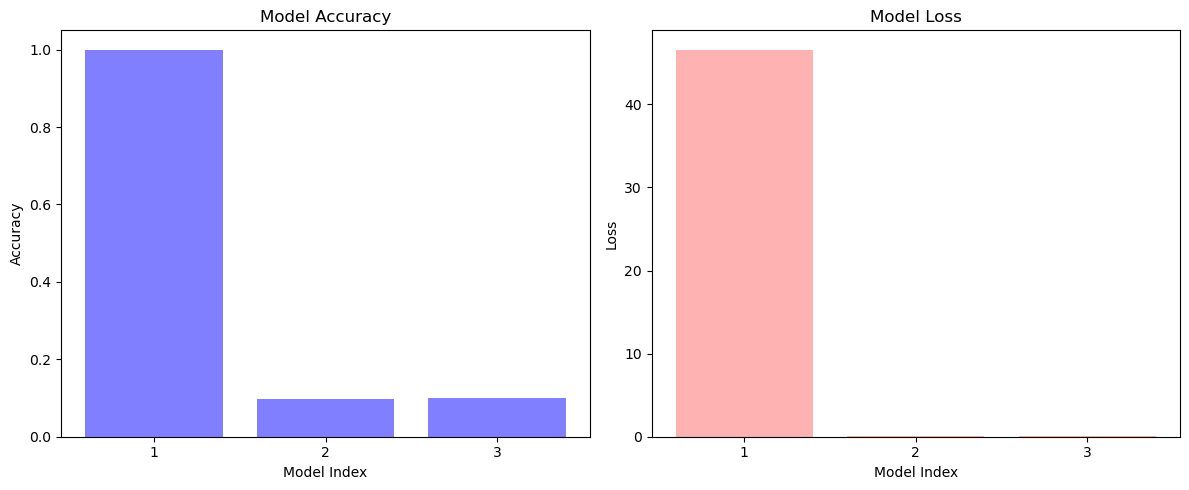

In [18]:

def load_model(file_path):
    """
    بارگذاری مدل از فایل
    """
    return tf.keras.models.load_model(file_path)

def evaluate_models(models, x_test, y_test):
    """
    ارزیابی مدل‌ها با استفاده از داده‌های تست و بازگشت نتایج
    
    Parameters:
        models (list): لیست مدل‌های بارگذاری‌شده
        x_test (numpy.ndarray): داده‌های تست
        y_test (numpy.ndarray): برچسب‌های تست
        
    Returns:
        list: لیست نتایج ارزیابی برای هر مدل (دقت و دیگر متریک‌ها)
    """
    results = []
    for model in models:
        # ارزیابی مدل
        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
        results.append((test_loss, test_acc))
    
    return results

def plot_results(results):
    """
    نمایش نتایج ارزیابی به صورت نمودار
    """
    losses, accuracies = zip(*results)
    
# تغییر مقادیر محور x به طوری که از 1 شروع شود
    x = range(1, len(results) + 1)    
    plt.figure(figsize=(12, 5))

    # نمودار دقت
    plt.subplot(1, 2, 1)
    plt.bar(x, accuracies, color='blue',alpha=0.5)
    plt.xticks(x)
    plt.xlabel('Model Index')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')

    # نمودار خطا
    plt.subplot(1, 2, 2)
    plt.bar(x, losses, color='red',alpha=0.3)
    plt.xticks(x)
    plt.xlabel('Model Index')
    plt.ylabel('Loss')
    plt.title('Model Loss')

    plt.tight_layout()
    plt.show()

# بارگذاری مدل‌ها
models = [load_model(f'client_model_{i}.h5') for i in range(n_clients)]

# ارزیابی مدل‌ها
results = evaluate_models(models, x_test, y_test)

# نمایش نتایج
plot_results(results)


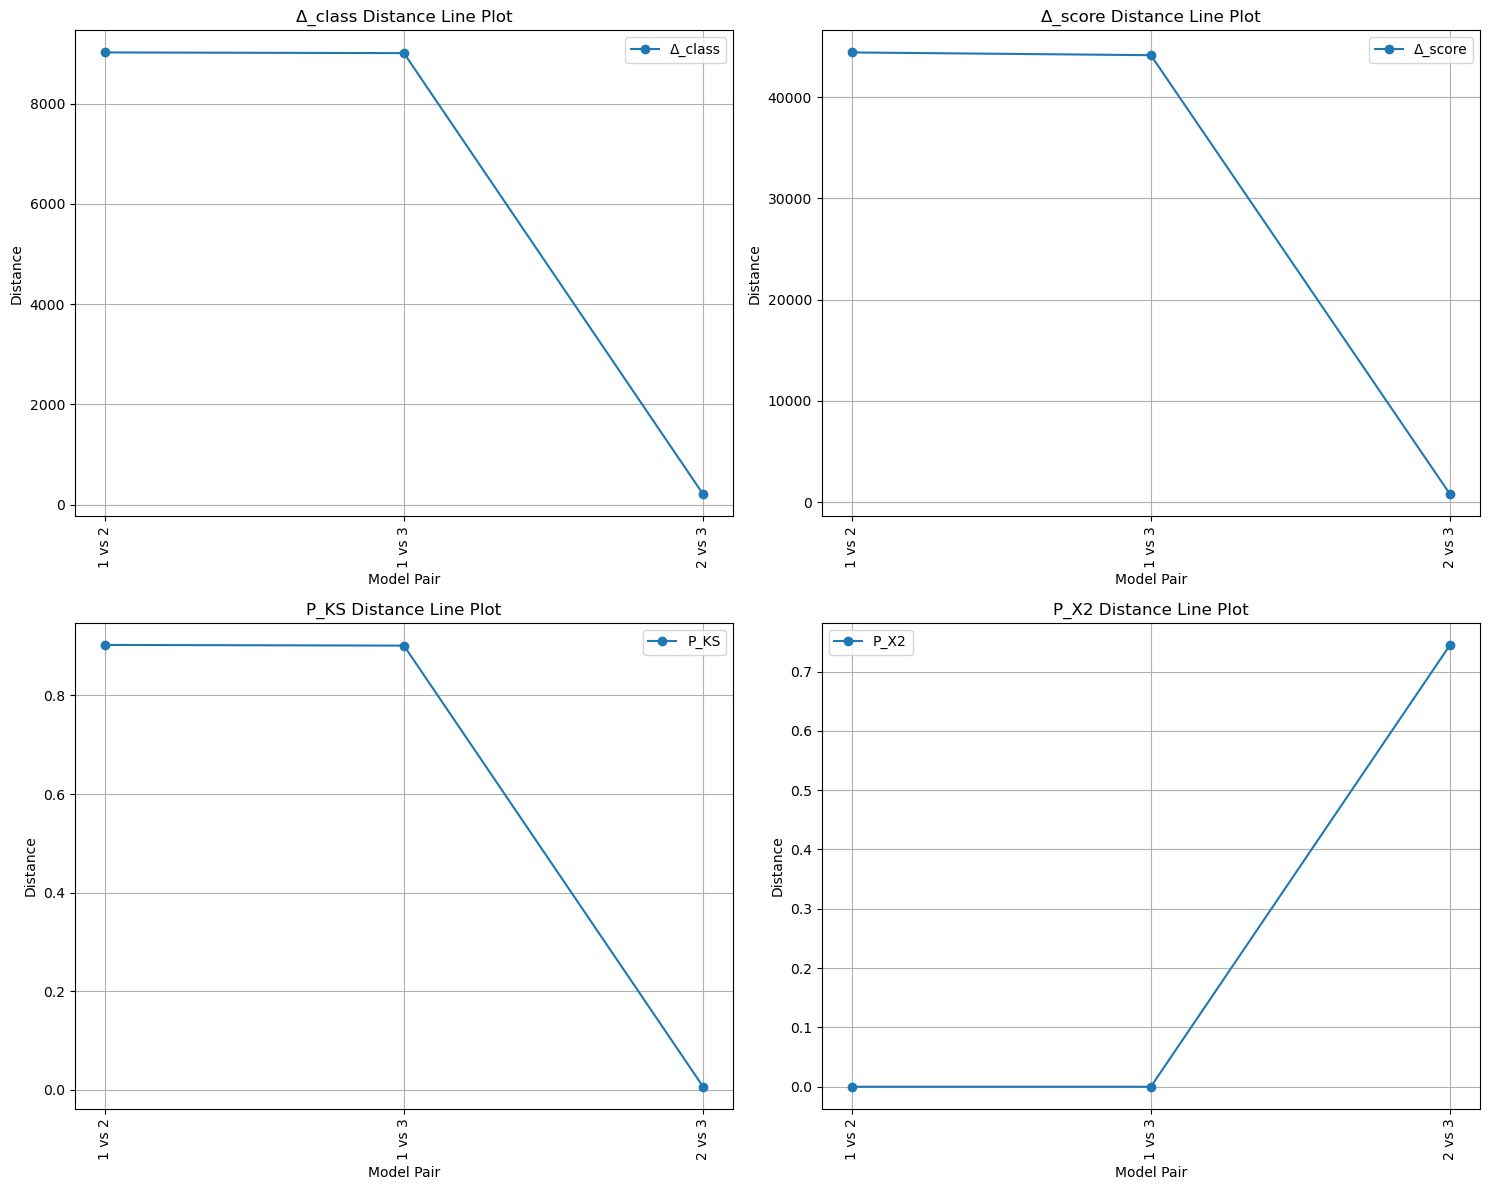

  Comparison  Δ_class  Δ_score    P_KS      P_X2
0     (1, 2)   9025.0  44409.0  0.9025  0.000000
1     (1, 3)   9011.0  44137.0  0.9011  0.000000
2     (2, 3)    205.0    790.0  0.0060  0.744883


In [19]:

def perform_differential_testing(preds1, preds2):
    """
    محاسبه متریک‌های تفاوت بین دو پیش‌بینی.
    
    Parameters:
        preds1 (array): پیش‌بینی‌های مدل اول
        preds2 (array): پیش‌بینی‌های مدل دوم
    
    Returns:
        tuple: مقادیر متریک‌ها (Δ_class, Δ_score, P_KS, P_X2)
    """
    # اطمینان از اینکه preds1 و preds2 به صورت یک‌بعدی هستند
    preds_class1 = np.argmax(preds1, axis=1).astype(int)
    preds_class2 = np.argmax(preds2, axis=1).astype(int)
    
    # تبدیل پیش‌بینی‌ها به برچسب‌های صحیح در صورتی که پیش‌بینی‌ها به صورت احتمالات باشند
    if preds1.ndim > 1:
        preds1 = np.argmax(preds1, axis=1)
    if preds2.ndim > 1:
        preds2 = np.argmax(preds2, axis=1)
         
    # محاسبه Δ_class
    Δ_class = np.sum(preds_class1 != preds2)
    
    # محاسبه Δ_score
    Δ_score = np.sum(np.abs(preds1 - preds2))
    
    # آزمون Kolmogorov-Smirnov برای نمرات
    P_KS, _ = stats.ks_2samp(preds1, preds2)
    
    # آزمون Chi-Squared برای کلاس‌ها
    bins = max(preds1.max(), preds2.max()) + 1
    contingency_table = np.array([np.bincount(preds1, minlength=bins), np.bincount(preds2, minlength=bins)])
    try:
        _, p_X2 = stats.chisquare(f_obs=contingency_table[0], f_exp=contingency_table[1])
    except ValueError:
        p_X2 = np.nan
       
    return Δ_class, Δ_score, P_KS, p_X2

def compute_distance_matrices(predictions_list):
    """
    محاسبه ماتریس‌های فاصله برای چهار متریک.
    
    Parameters:
        predictions_list (list): لیست پیش‌بینی‌های مدل‌ها
        
    Returns:
        dict: دیکشنری حاوی ماتریس‌های فاصله برای هر متریک
    """
    n_models = len(predictions_list)
    distance_matrices = {
        'Δ_class': np.zeros((n_models, n_models)),
        'Δ_score': np.zeros((n_models, n_models)),
        'P_KS': np.zeros((n_models, n_models)),
        'P_X2': np.zeros((n_models, n_models))
    }
    
    for i in range(n_models):
        for j in range(i + 1, n_models):  # فقط مقایسه‌های منحصر به فرد
            preds1 = predictions_list[i]
            preds2 = predictions_list[j]
            Δ_class, Δ_score, P_KS, P_X2 = perform_differential_testing(preds1, preds2)
            distance_matrices['Δ_class'][i, j] = Δ_class
            distance_matrices['Δ_class'][j, i] = Δ_class
            distance_matrices['Δ_score'][i, j] = Δ_score
            distance_matrices['Δ_score'][j, i] = Δ_score
            distance_matrices['P_KS'][i, j] = P_KS
            distance_matrices['P_KS'][j, i] = P_KS
            distance_matrices['P_X2'][i, j] = P_X2
            distance_matrices['P_X2'][j, i] = P_X2
    
    return distance_matrices



def plot_distance_matrices_lines(distance_matrices):
    """
    ترسیم نمودارهای خطی برای مقادیر متریک‌ها به ازای هر مقایسه مدل‌ها.
    
    Parameters:
        distance_matrices (dict): دیکشنری حاوی ماتریس‌های فاصله برای هر متریک
    """
    plt.close('all')
    
    metrics = list(distance_matrices.keys())
    n_models = len(distance_matrices[metrics[0]])  # تعداد مدل‌ها از اولین متریک گرفته می‌شود

    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    titles = [
        'Δ_class Distance Line Plot', 
        'Δ_score Distance Line Plot', 
        'P_KS Distance Line Plot', 
        'P_X2 Distance Line Plot'
    ]
    
    for ax, metric, title in zip(axs.flatten(), metrics, titles):
        distances = distance_matrices[metric]
        comparisons = []
        values = []
        # جمع‌آوری مقادیر فاصله برای نمودار
        for i in range(n_models):
            for j in range(i + 1, n_models):
                comparisons.append(f'{i + 1} vs {j + 1}')
                values.append(distances[i, j])
                
        ax.plot(comparisons, values, marker='o', linestyle='-', label=metric)
        ax.set_title(title)
        ax.set_xlabel('Model Pair')
        ax.set_ylabel('Distance')
        ax.legend()
        ax.grid(True)
        ax.set_xticklabels(comparisons, rotation=90)
    
    plt.tight_layout()
    plt.show()



def print_metric_tables(distance_matrices):
    """
    نمایش مقادیر متریک‌ها به صورت جدول.
    
    Parameters:
        distance_matrices (dict): دیکشنری حاوی ماتریس‌های فاصله برای هر متریک
    """
    rows = []
    metrics = list(distance_matrices.keys())
    n_models = len(distance_matrices[metrics[0]])  # تعداد مدل‌ها
    
    for i in range(n_models):
        for j in range(i + 1, n_models):  # فقط مقایسه‌های منحصر به فرد
            row = {'Comparison': f'({i + 1}, {j + 1})'}
            for metric in metrics:
                row[metric] = distance_matrices[metric][i, j]
            rows.append(row)
    
    df = pd.DataFrame(rows)
    print(df)


# فرض می‌کنیم predictions_list شامل پیش‌بینی‌های مدل‌ها است
predictions_list = [model.predict(x_test) for model in models]

# محاسبه ماتریس‌های فاصله
distance_matrices = compute_distance_matrices(predictions_list)

# نمایش نمودارهای خطی
plot_distance_matrices_lines(distance_matrices)

# نمایش مقادیر متریک‌ها به صورت جدول
print_metric_tables(distance_matrices)


In [32]:
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd

def apply_dbscan(distance_matrix, eps_values, min_samples_values, threshold=0.05):
    results = {}
    num_models = len(distance_matrix)
    comparisons = [(i + 1, j + 1) for i in range(num_models) for j in range(i + 1, num_models)]
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
            labels = dbscan.fit_predict(distance_matrix)
            
            # پیدا کردن اندیس‌هایی که به عنوان outliers شناسایی شده‌اند
            outliers = np.where(labels == -1)[0]
            
            # فیلتر کردن مقایسه‌ها براساس مقدار آستانه
            filtered_outliers = []
            for i in outliers:
                comp = comparisons[i]
                # ks_value = distance_matrix[comp[0] - 1, comp[1] - 1]
                # x2_value = distance_matrix[comp[0] - 1, comp[1] - 1]
                ks_value = distance_matrices['P_KS'][comp[0] - 1, comp[1] - 1]
                x2_value = distance_matrices['P_X2'][comp[0] - 1, comp[1] - 1]
                
                # بررسی مقادیر با آستانه
                if ks_value < threshold and x2_value < threshold:
                    filtered_outliers.append(comp)
            
            # مقایسه‌های فیلتر شده
            outlier_comparisons = [comp for comp in comparisons if comp in filtered_outliers]
            
            results[(eps, min_samples)] = {
                'num_outliers': len(filtered_outliers),
                'outliers': filtered_outliers,
                'outlier_comparisons': outlier_comparisons
            }
    
    return results




def print_dbscan_results(distance_matrices, eps_values, min_samples_values):
    summary_results = []
    detailed_results = []
    
    metrics = list(distance_matrices.keys())
    
    for metric in metrics:
        distance_matrix = distance_matrices[metric]
        dbscan_results = apply_dbscan(distance_matrix, eps_values, min_samples_values)
        
        num_models = len(distance_matrix)
        model_configurations = generate_hyperparameters(num_models)
        comparisons = [(i + 1, j + 1) for i in range(num_models) for j in range(i + 1, num_models)]
        
        for params, result in dbscan_results.items():
            eps, min_samples = params
            summary_results.append({
                'eps': eps,
                'min-samples': min_samples,
                metric: result['num_outliers']
            })
            
            detailed_results.append({
                'metric': metric,
                'eps': eps,
                'min-samples': min_samples,
                'outliers': result['num_outliers'],
                'comparisons': result['outliers'],
                # 'configurations': [(comp, model_configurations[comp[0] - 1], model_configurations[comp[1] - 1]) for comp in result['outlier_comparisons']]
                'configurations': [(comp, model_configurations[comp[0] - 1], model_configurations[comp[1] - 1]) for comp in result['outliers']]

            })
    
    summary_df = pd.DataFrame(summary_results)
    summary_pivot = summary_df.pivot_table(index=['eps', 'min-samples'], columns=None, fill_value=0)
    
    print("\nOutlier Counts by Metric:")
    print(summary_pivot)
    
    for result in detailed_results:
        print(f"\neps: {result['eps']}, min_samples: {result['min-samples']}")
        print(f"Number of outliers for {result['metric']}: {result['outliers']}")
        print("Outliers Comparisons with model configurations:")
        for comp, config1, config2 in result['configurations']:
            print(f"Comparison {comp}: Model 1 (learning-rate = {config1['learning_rate']}, dropout = {config1['dropout_rate']}), "
                  f"Model 2 (learning-rate = {config2['learning_rate']}, dropout = {config2['dropout_rate']})")

# فرض بر این است که distance_matrices شامل ماتریس‌های فاصله است
eps_values = [0.5, 1, 200, 600,900]
min_samples_values = [2, 3, 5]

# نمایش نتایج DBSCAN
print_dbscan_results(distance_matrices, eps_values, min_samples_values)



Outlier Counts by Metric:
                   P_KS  P_X2  Δ_class  Δ_score
eps   min-samples                              
0.5   2               0     0        0        0
      3               0     0        0        0
      5               0     0        0        0
1.0   2               0     0        0        0
      3               0     0        0        0
      5               0     0        0        0
200.0 2               0     0        0        0
      3               0     0        0        0
      5               0     0        0        0
600.0 2               0     0        0        0
      3               0     0        0        0
      5               0     0        0        0

eps: 0.5, min_samples: 2
Number of outliers for Δ_class: 0
Outliers Comparisons with model configurations:

eps: 0.5, min_samples: 3
Number of outliers for Δ_class: 0
Outliers Comparisons with model configurations:

eps: 0.5, min_samples: 5
Number of outliers for Δ_class: 0
Outliers Comparisons with